# RSCAM Week 4 exercises

**[0] Please rename your submitted file in the format `firstname_lastname.ipynb` using _File->Rename_.**

### Simulating Langevin dynamics

We assume we have some complicated potential energy function $U(q)$, and the target distribution $\rho_\beta(q)$ where 
$$\rho_\beta(q) = \frac1{Z_\beta} \exp(-\beta U(q)),\qquad Z_\beta=\int_{-\infty}^\infty \exp(-\beta U(q) )\,\rm{d}q.$$
Ultimately we want to compute averages with respect to this distribution, which we can write as an integral against $\rho_\beta(q)$.

If we augment our distribution to include momentum $p$, then we can write 
$$\rho_\beta(q,p) = \frac1{\hat{Z}_\beta} \exp(-\beta H(q,p) ),\qquad \hat{Z}_\beta=\int_{-\infty}^\infty \exp(-\beta H(q,p) )\,\rm{d}q\rm{d}p,$$
where $H$ is the familiar Hamiltonian, or total energy function, that we've seen before
$$H(q,p) = \frac12 \|p\|^2 + U(q)$$
where we have assumed mass is 1 for all degrees of freedom.

As $q$ and $p$ are independent, we can integrate out over the momentum variables and recover the correct sampling in $q$.

The momentum variables are useful as they can allow a system to continue going in an unfavourable direction (i.e. up barriers) via inertia. This property is lacking in, for example, the Brownian dynamics example in Week 3.

The equations of motion for Langevin dynamics are
$${ \begin{array}{rcl}
\dot{q} &=& p\\
\dot{p} &=& -\nabla U(q) - \gamma p + \sqrt{2\gamma /\beta} \dot{W}\end{array}}$$
where $W$ is a Wiener process, and $\gamma>0$ is a _friction constant_ parameter that describes how rapidly the momentum is randomized ($\gamma$ is like a rate). Note that is $\gamma=0$ then we reduce to the constant energy dynamics that we looked at in Weeks 1 and 2. If $\gamma$ is large, or infinite, then solutions will tend towards solutions to Brownian dynamics we generated in Week 3.

We can rewrite this as the sum of three terms:


$$\left[ \begin{array}{c} \dot{q}\\ \dot{p} \end{array}\right]
= \underbrace{\left[\begin{array}{c} p \\0 \end{array}\right]}_\text{A}
+ \underbrace{\left[\begin{array}{c} 0\\F(q) \end{array}\right]}_\text{B}
+ \underbrace{\left[\begin{array}{c} 0\\-\gamma p + \sqrt{2\gamma/\beta} \dot{W} \end{array}\right]}_\text{O}.$$
As usual $F(q)=-\nabla U(q)$ denotes the force.

We can solve each of the pieces _exactly_ in an average sense:

$$\text{(A) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) + h  p(t) \\
\qquad p(t+h)&\leftarrow&p(t)
\end{array}\right.$$

$$\text{(B) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
\qquad p(t+h)&\leftarrow&p(t) + h F(q(t))
\end{array}\right.$$

$$\text{(O) dynamics step}$$
$$ \left| \begin{array}{rcl} 
q(t+h)&\leftarrow&q(t) \\
R(t+h)&\leftarrow& \text{Normal}(0,I)\\
\qquad p(t+h)&\leftarrow&\exp(-\gamma h) p(t) + \sqrt{1/\beta}\sqrt{1-\exp(-2\gamma h)} R(t+h)
\end{array}\right.$$

The solution of the O step comes from the solution for the Ornstein-Uhlenbeck process, with $R(t)\in\mathbb{R}^N$ a vector of independent and identically distributed (i.i.d.) normal random numbers.

In [1]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt 

**[1] Complete the `B_step` and `O_step` functions below to match the above algorithms.**

In [10]:
def A_step( qp , h ):
    q,p = qp
    
    q = q + h*p
    p = p 
    
    return [q,p]

def B_step( qp , h, force ):
    q,p = qp
    
    # Your code here
    q = q
    p = p + h*force(q)

    return [q,p]

def O_step( qp , h,gamma ):
    q,p = qp
    
    # Your code here
    q = q
    R_t = np.random.randn(len(q))
    p = np.exp(-gamma*h)*p + np.sqrt(1-np.exp(-2*gamma*h))*R_t
    
    return [q,p]



We can then define a method integrating Langevin Dynamics by performing these in sequence. For example, the _ABO_ method looks like this:

In [3]:
def ld_ABO(q,p,h,gamma,force):
    
    # The algorithm "ABO" does A then B then O 
    
    qp = [q,p]
    
    A = A_step(qp , h )
    AB = B_step( A, h, force)
    ABO = O_step( AB, h, gamma )
    q,p = ABO
    
    return q , p 

We can feed this function into our `run_simulation` function to try running it:

In [4]:
def run_simulation( q0,p0, Nsteps, h, gamma, step_function, force_function):
    
    q_traj = [np.copy(q0)] 
    p_traj = [np.copy(p0)]
    t_traj = [0]

    q = np.copy(q0) 
    p = np.copy(p0)
    t = 0 

    for n in range(Nsteps):
        q,p = step_function(q, p, h, gamma, force_function)
        t = t + h 

        q_traj += [q] 
        p_traj += [p]   
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    p_traj = np.array(p_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, p_traj, t_traj



Rather than taking many walkers and looking at the evolving distributions, usually we will take one walker and run a long simulation. It can be shown that taking averages over this long simulation is equivalent to looking at the large time limit of lots of walkers, i.e. time averages along a trajectory will still equal averages with respect to the target distribution.

For example, for a Gaussian we can look at the sampled distributions:

In [20]:
def force_Gaussian(q):
    # U(q) = q^2 /2
    F = -q 
    return F

# Initialize one walker from a Gaussian distribution

q0 = np.random.randn(1)
p0 = np.random.randn(1)

Nsteps = 10000
h = 0.9
gamma = 1.0

# Run one long trajectory of Nsteps, using the ABO scheme
q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, ld_ABO, force_Gaussian)

And then plot the resulting distributions in $q$ and $p$:

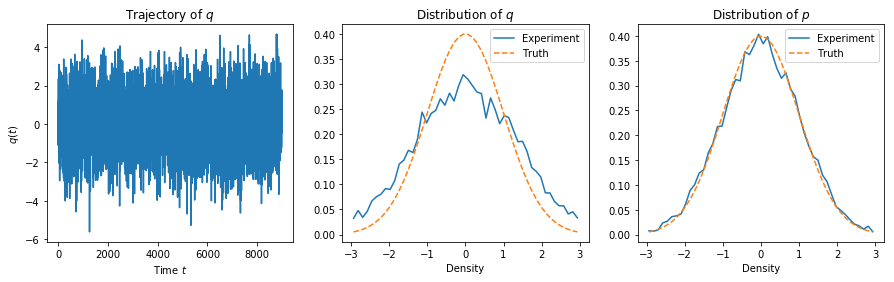

In [21]:
fig = plt.figure(figsize=[15,4])

plt.subplot(1,3,1)
plt.plot( t_traj, q_traj )
plt.title('Trajectory of $q$')
plt.ylabel('$q(t)$')
plt.xlabel('Time $t$')

plt.subplot(1,3,2) 
histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- (midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.xlabel('Density')
plt.legend()

plt.subplot(1,3,3) 
histogram,bins = np.histogram(p_traj,bins=50,range=[-3,3], density=True)
midx = (bins[0:-1]+bins[1:])/2
rho = np.exp(- (midx**2)/2)
rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx,histogram,label='Experiment')
plt.plot(midx,rho,'--',label='Truth')
plt.title('Distribution of $p$')
plt.xlabel('$p$')
plt.xlabel('Density')
plt.legend()
plt.show()

**[2] Implement the _OBABO_ and _BAOAB_ step methods.**

*(Recall that if a character appears twice in the string then that character's step is only for $h/2$, rather than $h$)*

In [32]:
def ld_OBABO(q,p,h,gamma,force):
    
    qp = [q,p]
    
    O = O_step( qp, h/2, gamma )
    OB = B_step( O, h/2, force)
    OBA = A_step(OB, h)
    OBAB = B_step(OBA, h/2, force)
    OBABO = O_step( OBAB, h/2, gamma )

    q,p = OBABO
    
    return q , p 

def ld_BAOAB(q,p,h,gamma,force):
    
    qp = [q,p]
    
    B = B_step( qp, h/2, force)
    BA = A_step(B, h/2)
    BAO = O_step( BA, h, gamma )
    BAOA = A_step(BAO, h/2)
    BAOAB = B_step( BAOA, h/2, force)

    q,p = BAOAB

    return q , p 


**[3] Compare the exact distribution to sampled distributions computed using _OBABO_ and _BAOAB_ by making a plot. Compute distributions in both $q$ and $p$, for the double-well potential energy function (below). Use a stepsize of $h=0.2$ with $\gamma=1$, **
$$U(q) = 2(q^2-1)^2$$

*(Run using one walker for a long enough simulation so that your histogram looks smooth. Include axis labels, legends and titles where necessary.)*

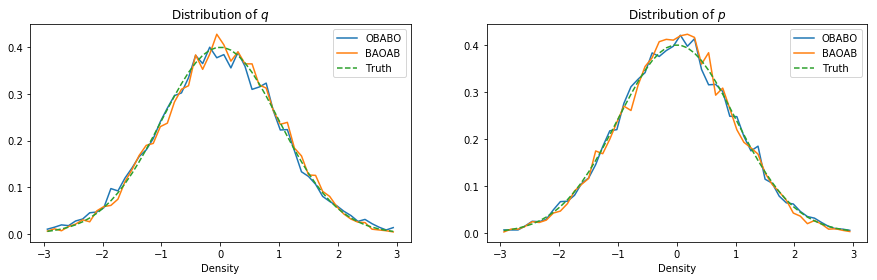

In [40]:

q0 = np.random.randn(1)
p0 = np.random.randn(1)

Nsteps = 10000
h = 0.5
gamma = 1.0

# Run one long trajectory of Nsteps, using the OBABO and BAOAB scheme
q_traj_OBABO, p_traj_OBABO, t_traj_OBABO = run_simulation(q0, p0, Nsteps , h, gamma, ld_OBABO, force_Gaussian)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, ld_BAOAB, force_Gaussian)


fig = plt.figure(figsize=[15,4])

# Distribution of q plot
plt.subplot(1,2,1) 
histogram_OBABO,bins_OBABO = np.histogram(q_traj_OBABO,bins=50,range=[-3,3], density=True)
midx_OBABO = (bins_OBABO[0:-1]+bins_OBABO[1:])/2
plt.plot(midx_OBABO,histogram_OBABO,label='OBABO')

histogram_BAOAB,bins_BAOAB = np.histogram(q_traj_BAOAB,bins=50,range=[-3,3], density=True)
midx_BAOAB = (bins_BAOAB[0:-1]+bins_BAOAB[1:])/2
plt.plot(midx_BAOAB,histogram_BAOAB,label='BAOAB')

rho = np.exp(- (midx_BAOAB**2)/2)
rho = rho / ( np.sum(rho) * (midx_BAOAB[1]-midx_BAOAB[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx_OBABO,rho,'--',label='Truth')
plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.xlabel('Density')
plt.legend()

# Distribution of p
plt.subplot(1,2,2) 
histogram_OBABO,bins_OBABO = np.histogram(p_traj_OBABO,bins=50,range=[-3,3], density=True)
midx_OBABO = (bins_OBABO[0:-1]+bins_OBABO[1:])/2
plt.plot(midx_OBABO,histogram_OBABO,label='OBABO')

histogram_BAOAB,bins_BAOAB = np.histogram(p_traj_BAOAB,bins=50,range=[-3,3], density=True)
midx_BAOAB = (bins_BAOAB[0:-1]+bins_BAOAB[1:])/2
plt.plot(midx_BAOAB,histogram_BAOAB,label='BAOAB')

rho = np.exp(- (midx_BAOAB**2)/2)
rho = rho / ( np.sum(rho) * (midx_BAOAB[1]-midx_BAOAB[0]) ) # Normalize rho by dividing by its approx. integral
plt.plot(midx_BAOAB,rho,'--',label='Truth')
plt.title('Distribution of $p$')
plt.xlabel('$p$')
plt.xlabel('Density')
plt.legend()
plt.show()

In [37]:
def force_DoubleWell(q):
    # U(q) = 2*(q^2-1)^2
    
    F = -8*q*(q**2-1) # Your code here 
    
    return F

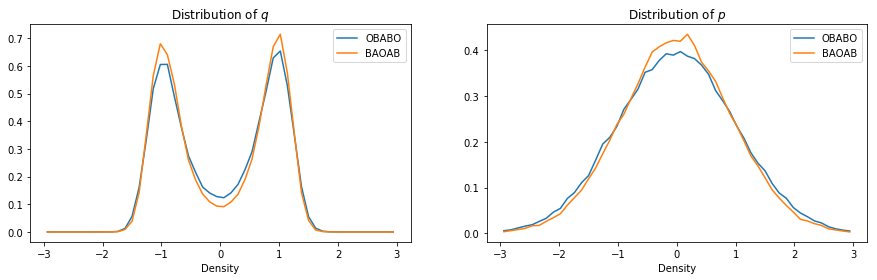

In [41]:
# The Double-well with OBABA and BAOAB

q0 = np.random.randn(1)
p0 = np.random.randn(1)

Nsteps = 100000
h = 0.2
gamma = 1.0

# Run one long trajectory of Nsteps, using the OBABO and BAOAB scheme
q_traj_OBABO, p_traj_OBABO, t_traj_OBABO = run_simulation(q0, p0, Nsteps , h, gamma, ld_OBABO, force_DoubleWell)
q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, ld_BAOAB, force_DoubleWell)


fig = plt.figure(figsize=[15,4])

# Distribution of q plot
plt.subplot(1,2,1) 
histogram_OBABO,bins_OBABO = np.histogram(q_traj_OBABO,bins=50,range=[-3,3], density=True)
midx_OBABO = (bins_OBABO[0:-1]+bins_OBABO[1:])/2
plt.plot(midx_OBABO,histogram_OBABO,label='OBABO')

histogram_BAOAB,bins_BAOAB = np.histogram(q_traj_BAOAB,bins=50,range=[-3,3], density=True)
midx_BAOAB = (bins_BAOAB[0:-1]+bins_BAOAB[1:])/2
plt.plot(midx_BAOAB,histogram_BAOAB,label='BAOAB')

plt.title('Distribution of $q$')
plt.xlabel('$q$')
plt.xlabel('Density')
plt.legend()

# Distribution of p
plt.subplot(1,2,2) 
histogram_OBABO,bins_OBABO = np.histogram(p_traj_OBABO,bins=50,range=[-3,3], density=True)
midx_OBABO = (bins_OBABO[0:-1]+bins_OBABO[1:])/2
plt.plot(midx_OBABO,histogram_OBABO,label='OBABO')

histogram_BAOAB,bins_BAOAB = np.histogram(p_traj_BAOAB,bins=50,range=[-3,3], density=True)
midx_BAOAB = (bins_BAOAB[0:-1]+bins_BAOAB[1:])/2
plt.plot(midx_BAOAB,histogram_BAOAB,label='BAOAB')


plt.title('Distribution of $p$')
plt.xlabel('$p$')
plt.xlabel('Density')
plt.legend()
plt.show()

One way we can estimate the rate at which the dynamics explores is by looking at the rate a trajectory spreads out in space. In this example, we shall look at barrier crossings, which we can count by looking at sign flips in $q$ (as the barrier's peak is at $q=0$). More sign flips in a trajectory mean more hops over the barrier between the left and right sides.

**[4] Count the average number of sign flips in $q(t)$ for $t\in[0,500]$ as a function of the choice of $\gamma$, and plot the results for some choices of $\gamma\in[10^{-2},10^2]$. Initialize the starting position to be $q(0)=1$, and the initial momentum to be a normal random number $p(0)=\text{Normal}(0,1)$.**

_(Use BAOAB with $h=0.05$ and $10,000$ steps. To get good statistics (i.e. a smooth curve), you should average over lots of runs. Proper formatting of your Figure, i.e. Axis label etc., is required. )_

_(NOTE: Loops are (usually) slow in Python. You should find a way to count the sign changes in a trajectory without looping over every element. Its advisable to try and do repeat experiments without looping as well. If successful, your code should run in minutes, instead of hours/years.)_

You should find that the curve is hump-shaped when $\gamma$ is on a log-scale, with $\gamma$ too small or too large giving fewer sign changes.

In [80]:
# number of runs
runs = 10
q0 = np.ones(runs)
p0 = np.random.randn(runs)

Nsteps = 10000
h = 0.05
gamma = np.linspace(0.01,100,4)
q_traj_BAOAB = np.zeros()


# Q4
for eachg in gamma:
    q_traj_BAOAB, p_traj_BAOAB, t_traj_BAOAB = run_simulation(q0, p0, Nsteps , h, gamma, ld_BAOAB, force_DoubleWell)
    np.where(!=)


ValueError: operands could not be broadcast together with shapes (4,) (10,) 

In [79]:
print(q_traj_BAOAB)

[[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 1.03952433  0.9332379   0.92836213 ...  1.03999704  1.02227934
   0.99886997]
 [ 1.06462822  0.87935944  0.85874248 ...  1.07271915  1.03480888
   1.00485279]
 ...
 [-0.86543907  0.8300703  -0.41995549 ...  0.70379154  0.95800687
   0.9239077 ]
 [-0.91482913  0.80111176 -0.36497337 ...  0.75603071  0.96901517
   0.92479228]
 [-0.96154167  0.79709724 -0.30987892 ...  0.79558     0.97854278
   0.93970906]]


***

### Bayesian inference in data science

The purpose of sampling is usually to calculate integrals with respect to a target distribution. We shall look at an application for this in Bayesian inference.

We will look at one example for inferring a statistical property (the masses of tomatoes) from data via sampling.

Let's assume there are three species of tomato: A, B and C. We will also assume that the masses of each species of tomato are normally distributed, with its mean mass being $\mu_A,\,\mu_B$ and $\mu_C$ grams, for each species respectively. We shall assume that the variance of the masses is 1 for each species.

So if I take a single tomato with mass $y$, assuming it has an equal chance of being from species A, B or C, the _probability distribution_ $\hat{\rho}$ of $y$ is just the sum of the three Gaussian distributions:

$$ \hat{\rho}(y\,|\,\mu_A,\mu_B,\mu_C) \propto \exp({-(y-\mu_A)^2/2}) + \exp({-(y-\mu_B)^2/2}) + \exp({-(y-\mu_C)^2/2})  $$

If we know the values of $\mu_A,\,\mu_B$ and $\mu_C$ then we can compute the probability distribution for $y$. But what if we have the data, but don't know these three Gaussian centres? We can use Bayes theorem to do the reverse: find the probability distribution for the centres given the data.

If we have a set of $N$ datapoints $Y = \{y_i\}$, then we can write the distribution for the centres as 

$$ \rho(\mu_A,\mu_B,\mu_C\,|\,Y) \propto  \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \prod_{i=1}^N \hat{\rho}(y_i\,|\,\mu_A,\mu_B,\mu_C),$$
where $\rho_\text{prior}$ is the _prior_ which regularizes the whole distribution, and $\hat{\rho}$ is the _likelihood_.

Our goal in this section will be to sample $\rho$ given some data $Y$. The distribution $\rho$ looks very different to the previous distributions we have seen, as there is no potential energy $U(q)$. We will think of $q=[\mu_A,\mu_B,\mu_C]$ and as we can write $\rho(q) = \exp(-\log(\rho(q)))$ we think of $U(q) = -\log(\rho(q))$.

Thus we have 

$$ U(\mu_A,\mu_B,\mu_C) = -\log( \rho_\text{prior}(\mu_A,\mu_B,\mu_C) ) - \sum_{i=1}^N \log( \hat{\rho}(y_i\,|\,\mu_A,\mu_B,\mu_C) )$$


In data science, $U$ is called the _log-posterior_ instead of the energy.

Let's load in the data we will be using: the masses of 30 different tomatoes (of species A, B or C) picked fresh this morning.

In [ ]:
Y=np.load('tomatoes.npy') # Make sure you downloaded this file from Learn!
print('Length of data: ' + str(len(Y)))
print('Data:')
print(Y)

And then we can make a histogram to look at the distribution of the data:

In [ ]:
histogram,bins = np.histogram(y,bins=10)
mid_bins = (bins[:-1]+bins[1:])/2
plt.bar(mid_bins,histogram,edgecolor='k')
plt.xlabel('Mass (g)')
plt.ylabel('Frequency')
plt.title('Tomato data')
plt.show()

We shall use a Gaussian prior with a large variance, just to keep us from sampling e.g. negative numbers. We will put the centre of the prior at 13.5, which is roughly the middle of the data.

$$ \rho_\text{prior}(\mu_A,\mu_B,\mu_C) \propto \exp({-(13.5-\mu_A)^2/32}) \exp({-(13.5-\mu_B)^2/32}) \exp({-(13.5-\mu_B)^2/32}) $$

**[5] Create a function that takes the value of the position $q$ and the data vector $y$, and outputs the value of $U(q)$.**

*(NOTE: Try to avoid using a loop to sum over all of the data as it will be very slow, and instead work with vectors as much as possible. Don't forget U includes the prior and the likelihood.)*

In [ ]:
def U(q,y):
    m1,m2,m3 = q 
    
    # Your code here 
    
    return V
    
    
    

In [ ]:
# To check:
U( [12,13,14], Y) - U( [11,12,13], Y)
# This should give 
# -23.67246392837439


**[6] Create a function that takes the position $q$ and data $y$ and returns the force $\nabla U(q)$. **

In [ ]:
def force(q,y):
    m1,m2,m3 = q  
    
    return ?
    

In [ ]:
force( [12,13,14], Y)
# This should give force components as 

#  -5.910649468415861,
# 0.7771208852796383,
# 17.537431144234255

**[7] Use your force routine to generate samples from $\rho$ by generating one long Langevin dynamics trajectory (i.e. over 10,000 steps).**

**Plot histograms of the distributions of $\mu_A,\mu_B,\mu_C$ on the same axis.**

You should see that the values will like to settle between three defined values.

*(You may use any Langevin scheme you wish to sample this problem. It is up to you to choose a sensible stepsize $h$ and friction $\gamma$, and run for long enough to get smooth curves.)*

It can be hard to visualize the system when we have more than two dimensions, so people often use a pair of _collective variables_ and plot results in those instead.

**[8] Plot a 2D histogram of your sampled trajectory in the $C_1$ and $C_2$ collective variable coordinates listed below.**

$$ C_1 = \mu_B - \mu_A $$
$$ C_2 = 2\mu_C - \mu_B - \mu_A $$

_(You may wish to plot the logarithm of the histogram value instead, which is more closely related to energy and makes a nice picture.)_

You should see six defined regions where sampling is concentrated.

The problem has a symmetry in it, due to invariance under label permutation (this is called _fungification_). This means that the six sampled regions above are really the same region just with some projection mapping between them. We can remove this by collapsing the results onto one well.

In general finding this projection can be very difficult, but here it is easy to accomplish. A transition between any of the six regions amounts to two of the $\mu$ values swapping positions, so we can undo that by sorting our trajectory to maintain a size ordering.

**[9] Use `np.sort` to create a copy of your trajectory with sorted components so that $\mu_A<\mu_B<\mu_C$. Plot a new histogram of the distributions of the sorted $\mu_A,\mu_B,\mu_C$ on the same axis, and print the means of each of the three coordinates.**

You should see that each density is concentrated around just one value.

**Optional:**
1. Use your A, B and O pieces to implement some higher-order Yoshida Langevin dynamics schemes.
2. Demonstrate that the long-time sampling error for OBABO is second order for $q^2$, and BAOAB is second-order for $p^2$, in the Gaussian case.
3. Compare stability for the BAOAB scheme in the case of the double-well potential as $\gamma$ is increased.
4. Modify the tomatoes example to include other parameters in the distribution, including component weights and variances. This is known as a Gaussian mixture model.
5. Find the height of the barrier between two of the regions in the six-region histogram.
6. Rerun Q4 for the data science example, counting the number of region changes instead of barrier hops.